In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

# Change to the directory where your datasets are stored
data_dir = '/content/drive/My Drive/NEST'
os.chdir(data_dir)

# List files in the directory
!ls


df_eligibilities.csv  merged_clinical_trials_cleaned.csv  usecase_1_.csv
df_usecase_1.csv      preprocessed_clinical_trials.csv	  usecase_2_TEST_gt_removed.csv
df_usecase_2.csv      tfidf_matrix_with_demo.npz	  usecase_3_.csv
df_usecase_3.csv      tfidf_matrix_without_demo.npz	  usecase_4_.csv
df_usecase_4.csv      tfidf_vectorizer_with_demo.pkl
eligibilities.csv     tfidf_vectorizer_without_demo.pkl


In [3]:
import pandas as pd

# Load the dataset
df_merged = pd.read_csv('/content/drive/My Drive/NEST/merged_clinical_trials_cleaned.csv')

# Verify the loaded DataFrame
print("DataFrame Loaded:")
print(df_merged.info())
# print(df_merged.head())

DataFrame Loaded:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343676 entries, 0 to 343675
Data columns (total 21 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   NCT Number                  343676 non-null  object 
 1   Study Title                 343676 non-null  object 
 2   Study URL                   343676 non-null  object 
 3   Study Status                343676 non-null  object 
 4   Brief Summary               343676 non-null  object 
 5   Study Type                  343676 non-null  object 
 6   Study Results               343676 non-null  object 
 7   Study Design                343676 non-null  object 
 8   Sponsor                     343676 non-null  object 
 9   Conditions                  343676 non-null  object 
 10  Interventions               343676 non-null  object 
 11  Primary Outcome Measures    343676 non-null  object 
 12  Secondary Outcome Measures  343676 non-null  object 
 

## data preparation

In [4]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# Text preprocessing function
def preprocess_text(text):
    if pd.isnull(text):
        return "unknown"
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^a-z\s]', '', text)  # Remove special characters, punctuation, and numbers
    stop_words = set(stopwords.words('english'))
    text = " ".join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    stemmer = PorterStemmer()
    text = " ".join([stemmer.stem(word) for word in text.split()])  # Stem words
    return text

# Preprocess text fields
text_columns = ['Study Title', 'Conditions', 'Criteria', 'Primary Outcome Measures', 'Secondary Outcome Measures']
for col in text_columns:
    df_merged[col] = df_merged[col].apply(preprocess_text)

In [9]:
# Handle missing values
df_merged.fillna({
    'Study Title': 'unknown',
    'Conditions': 'unknown',
    'Criteria': 'unknown',
    'Primary Outcome Measures': 'unknown',
    'Secondary Outcome Measures': 'unknown',
    'Phases': 'unknown',
    'Age_group': 'unknown',
    'Sex': 'unknown',
    'Enrollment': 0,
    'Healthy_volunteers': 'unknown',
    'Locations': 'unknown',
}, inplace=True)


In [10]:
# Normalize categorical columns
df_merged['Phases'] = df_merged['Phases'].str.replace('Phase ', '', regex=False).str.strip()
df_merged['Phases'] = df_merged['Phases'].replace({'1/2': '1-2', '2/3': '2-3'}).fillna('unknown')
df_merged['Age_group'] = df_merged['Age_group'].str.lower().replace({'children': 'child', 'elderly': 'older_adult'}).fillna('unknown')
df_merged['Sex'] = df_merged['Sex'].str.lower().replace({'male': 'male', 'female': 'female', 'all': 'all'}).fillna('unknown')

In [ ]:
# Save the preprocessed DataFrame to a CSV file
df_merged.to_csv('preprocessed_clinical_trials.csv', index=False)

# Confirmation message
print("Preprocessed dataset saved as 'preprocessed_clinical_trials.csv'")

## Building the similarity model

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

### Implement TF-IDF Similarity With Age_group and Sex

In [12]:
# Combine text fields WITH Age_group and Sex
df_merged['combined_text_with_demo'] = (
    df_merged['Study Title'] + " " +
    df_merged['Conditions'] + " " +
    df_merged['Criteria'] + " " +
    df_merged['Interventions'] + " " +
    df_merged['Primary Outcome Measures'] + " " +
    df_merged['Secondary Outcome Measures'] + " " +
    df_merged['Age_group'] + " " +
    df_merged['Sex']
)

# Preprocess and TF-IDF Vectorization
vectorizer_with_demo = TfidfVectorizer(stop_words='english', max_features=10000, ngram_range=(1, 2))
tfidf_matrix_with_demo = vectorizer_with_demo.fit_transform(df_merged['combined_text_with_demo'])

# Normalize TF-IDF Matrix
tfidf_matrix_with_demo = normalize(tfidf_matrix_with_demo)

# Function to retrieve similar trials
def find_similar_trials_with_demo(nct_number, top_n=10):
    trial_index = df_merged[df_merged['NCT Number'] == nct_number].index[0]
    similarity_scores = cosine_similarity(tfidf_matrix_with_demo[trial_index], tfidf_matrix_with_demo).flatten()
    similar_indices = similarity_scores.argsort()[::-1][1:top_n + 1]
    similar_trials = df_merged.iloc[similar_indices].copy()
    similar_trials['Similarity Score'] = similarity_scores[similar_indices]
    return similar_trials[['NCT Number', 'Study Title', 'Conditions', 'Similarity Score']]


In [13]:
example_nct_number = 'NCT00386607'  # Replace with a valid NCT Number

# Find similar trials WITH Age_group and Sex
similar_trials_with_demo = find_similar_trials_with_demo(example_nct_number)
print("\nSimilar Trials WITH Age_group and Sex:")
print(similar_trials_with_demo)


Similar Trials WITH Age_group and Sex:
         NCT Number                                        Study Title  \
53188   NCT00787605  aliskiren hctz compar amlodipin patient stage ...   
24556   NCT00333489  compar studi valsartan amlodipin versu amlodip...   
163548  NCT02620163  efficaci safeti studi yh vs telmisartanamlodip...   
53785   NCT00797316  aliskiren plu hctz compar aliskiren metabol sy...   
152791  NCT02433119  efficaci safeti orosartan versu codiovan patie...   
26736   NCT00368277  safeti efficaci trial aliskiren mg mg compar r...   
61856   NCT00927394  aliskiren valsartan vs valsartan alon patient ...   
23117   NCT00311012                          spp dose find studi japan   
28102   NCT00389675  doradoacex longterm safeti extens studi phase ...   
117005  NCT01828359  efficaci safeti studi antihypertens combin dru...   

                        Conditions  Similarity Score  
53188   hypertensiondiabet mellitu          0.722069  
24556                    hypertens 

In [14]:
example_nct_number = 'NCT00385736'  # Replace with a valid NCT Number

# Find similar trials WITH Age_group and Sex
similar_trials_with_demo = find_similar_trials_with_demo(example_nct_number)
print("\nSimilar Trials WITH Age_group and Sex:")
print(similar_trials_with_demo)



Similar Trials WITH Age_group and Sex:
         NCT Number                                        Study Title  \
229517  NCT03844932  studi evalu efficaci safeti st subject moder s...   
162469  NCT02601300  efficaci safeti studi mongersen ged subject ac...   
97558   NCT01506362  efficaci pharmacodynam safeti toler oral bl pa...   
57280   NCT00853099  studi adalimumab japanes subject moder sever a...   
119094  NCT01863771  safeti effect studi golimumab japanes patient ...   
156591  NCT02499263  prospect nonintervent multicent studi evalu ef...   
34255   NCT00487539  efficaci safeti studi golimumab cnto particip ...   
144497  NCT02289417  efficaci safeti studi apremilast treat activ u...   
199713  NCT03281304  studi tofacitinib patient ulcer coliti stabl r...   
131156  NCT02065557  efficaci safeti adalimumab pediatr subject mod...   

          Conditions  Similarity Score  
229517  coliti ulcer          0.773888  
162469  coliti ulcer          0.759906  
97558   ulcer coliti  

In [15]:
example_nct_number = 'NCT03518073'  # Replace with a valid NCT Number

# Find similar trials WITH Age_group and Sex
similar_trials_with_demo = find_similar_trials_with_demo(example_nct_number)
print("\nSimilar Trials WITH Age_group and Sex:")
print(similar_trials_with_demo)


Similar Trials WITH Age_group and Sex:
         NCT Number                                        Study Title  \
173075  NCT02791191  studi ly diseas progress particip mild alzheim...   
267712  NCT04640077  followon studi donanemab ly video assess parti...   
204365  NCT03367403  studi ly particip earli symptomat alzheim dise...   
74309   NCT01127633  continu safeti monitor solanezumab ly alzheim ...   
208475  NCT03443973  safeti efficaci studi gantenerumab particip ea...   
208526  NCT03444870  efficaci safeti studi gantenerumab particip ea...   
161275  NCT02580305  suvn donepezil memantin treatment moder alzhei...   
127731  NCT02008357  clinic trial solanezumab older individu may ri...   
182806  NCT02972658  studi lanabecestat ly earli alzheim diseas dem...   
155379  NCT02477800  ad phase studi aducanumab biib earli alzheim d...   

                                               Conditions  Similarity Score  
173075                                     alzheim diseas          

### Heatmaps Showing Similarity Scores

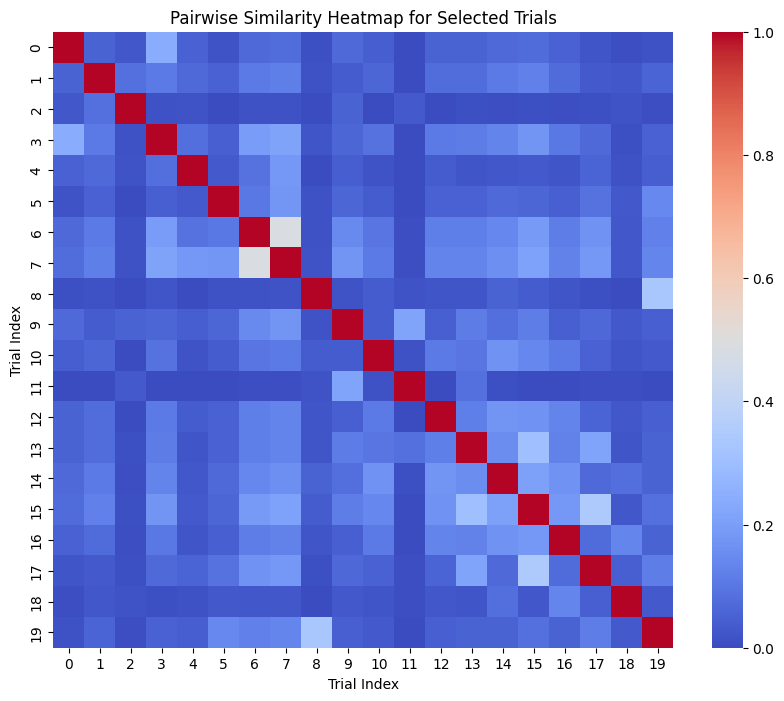

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# Select a subset of trials (example: first 20 rows)
subset_indices = df_merged.index[:20]
subset_tfidf = tfidf_matrix_with_demo[subset_indices]

# Compute pairwise cosine similarity
pairwise_similarity = cosine_similarity(subset_tfidf)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pairwise_similarity, annot=False, cmap="coolwarm")
plt.title("Pairwise Similarity Heatmap for Selected Trials")
plt.xlabel("Trial Index")
plt.ylabel("Trial Index")
plt.show()


### Average Similarity Score for a Set of Queries

In [17]:
query_trials = ['NCT00385736', 'NCT00386607', 'NCT03518073']  # Replace with valid NCT Numbers
average_scores = []

for query in query_trials:
    # Find similar trials
    similar_trials = find_similar_trials_with_demo(query, top_n=10)
    # Compute average similarity score for top N trials
    avg_score = similar_trials['Similarity Score'].mean()
    average_scores.append(avg_score)

# Overall average similarity score
overall_avg_similarity = sum(average_scores) / len(average_scores)
print(f"Average Similarity Score for Queries: {overall_avg_similarity:.3f}")


Average Similarity Score for Queries: 0.643


### Time Taken to Compute Similarities

In [18]:
import time

# Measure time for similarity computation
start_time = time.time()

# Compute similarities for a set of queries
for query in ['NCT00385736', 'NCT00386607', 'NCT03518073']:
    find_similar_trials_with_demo(query, top_n=10)

end_time = time.time()
time_taken = end_time - start_time
print(f"Time Taken for Similarity Computation: {time_taken:.2f} seconds")

Time Taken for Similarity Computation: 3.82 seconds


### Implement Grid Search for TF-IDF parameters.

In [19]:
from sklearn.model_selection import ParameterGrid
import numpy as np

In [ ]:
# Function to evaluate the similarity scores
def evaluate_similarity(tfidf_matrix):
    similarity_scores = cosine_similarity(tfidf_matrix)

    # Compute mean top-10 similarity scores for all trials
    mean_top_similarity = []
    for i in range(similarity_scores.shape[0]):
        top_scores = np.sort(similarity_scores[i])[-11:-1]  # Top 10 excluding self
        mean_top_similarity.append(np.mean(top_scores))

    return np.mean(mean_top_similarity)

# Define the parameter grid
param_grid = {
    'max_features': [10000, 20000, 50000],
    'ngram_range': [(1, 1), (1, 2), (1, 3)],
    'min_df': [2, 5, 10],
    'max_df': [0.75, 0.85, 0.9]
}

# Initialize variables to track the best parameters
best_params = None
best_score = -1

# Run the grid search
for params in ParameterGrid(param_grid):
    print(f"Testing parameters: {params}")

    # Initialize the vectorizer with the current parameters
    vectorizer = TfidfVectorizer(
        stop_words='english',
        max_features=params['max_features'],
        ngram_range=params['ngram_range'],
        min_df=params['min_df'],
        max_df=params['max_df']
    )

    # Fit-transform the combined_text_with_demo field
    tfidf_matrix = vectorizer.fit_transform(df_merged['combined_text_with_demo'])
    tfidf_matrix = normalize(tfidf_matrix)  # Normalize the TF-IDF matrix

    # Evaluate similarity scores
    score = evaluate_similarity(tfidf_matrix)
    print(f"Mean Top-10 Similarity Score: {score}")

    # Update the best parameters if the current score is better
    if score > best_score:
        best_score = score
        best_params = params

# Print the best parameters and score
print("\nBest Parameters for TF-IDF:")
print(best_params)
print(f"Best Mean Top-10 Similarity Score: {best_score}")

Testing parameters: {'max_df': 0.75, 'max_features': 10000, 'min_df': 2, 'ngram_range': (1, 1)}


### explainability with SHAP

In [ ]:
import shap

# Function to compute similarity between trials
def calculate_similarity(tfidf_matrix, trial_index):
    similarity_scores = cosine_similarity(tfidf_matrix[trial_index], tfidf_matrix).flatten()
    return similarity_scores

# Example: Choose a trial to explain
example_nct_number = 'NCT02451735'  # Replace with a valid NCT Number
trial_index = df_merged[df_merged['NCT Number'] == example_nct_number].index[0]

# Compute similarity scores for all trials
similarity_scores = calculate_similarity(tfidf_matrix_with_demo, trial_index)

# Extract the vector for the specific trial
example_vector = tfidf_matrix_with_demo[trial_index].toarray()

# Use SHAP to explain the similarity
explainer = shap.Explainer(lambda x: cosine_similarity(x, tfidf_matrix_with_demo).flatten(), example_vector)
shap_values = explainer(example_vector)

# Plot the SHAP values
shap.summary_plot(shap_values, feature_names=vectorizer_with_demo.get_feature_names_out())


In [ ]:
# Generate a force plot for a specific trial comparison
shap.force_plot(shap_values[0], feature_names=vectorizer_with_demo.get_feature_names_out())